In [1]:
# Aarjav Jain
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
from __future__ import division, print_function
from pylab import plot, xlabel, ylabel, show

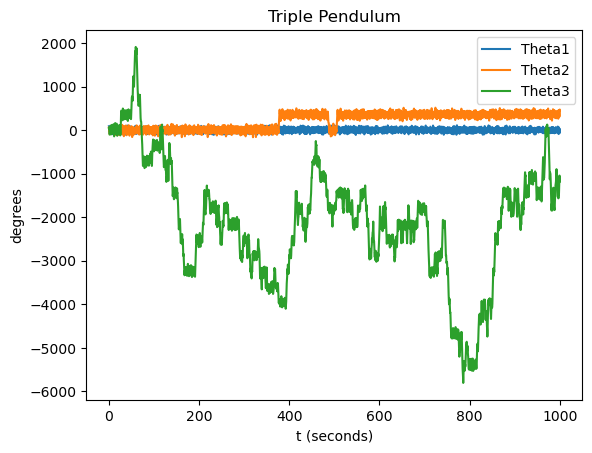

In [13]:
g = 9.81
l1 = 1
l2 = 1
l3= 1
m1 = 1.0
m2 = 1.0
m3 = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def f(q, t):
    '''Triple Pendulum equation of motion'''

    # Define relevant parameters

    # Define useful mass combinations
    m12 = m2 + m3
    m012 = m1 + m2 + m3
    mf = m012/4

    # Define useful sines
    sin0 = np.sin(q[0])
    sin1 = np.sin(q[2])
    sin2 = np.sin(q[4])

    # Define useful sine and cosine of differences
    cos01 = np.cos(q[0]-q[2])
    cos02 = np.cos(q[0]-q[4])
    cos12 = np.cos(q[2]-q[4])
    sin01 = np.sin(q[0]-q[2])
    sin02 = np.sin(q[0]-q[4])
    sin12 = np.sin(q[2]-q[4])

    # Define useful recurrent patterns
    r1 = m12*cos01*cos02 - m012*cos12
    r2 = m012 - m12*(cos01)**2
    r3 = -m012 + m3*(cos02)**2

    # Define parts of the first equation
    od1_1 = 4*m3*m12
    od1_2 = r1*cos01 + r2*cos02
    od1_3 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od1_4 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2
    od1_5 = -m3*m12*( -cos02 + np.cos(q[0]-2*q[2]+q[4]) )**2 * m012
    od1_6 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od1_7 = m3*r1**2 + m12*r3*r2

    # Define parts of the second equation
    od2_1 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od2_2 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od2_3 = -g*m2*sin1 - g*m3*sin1 + l1*m2*sin01*q[1]**2 + l1*m3*sin01*q[1]**2 - l3*m3*sin12*q[5]**2

    # Define parts of the thirds equation
    od3_1 = g*m1*sin0 + g*m2*sin0 + g*m3*sin0 + l2*m2*sin01*q[3]**2 + l2*m3*sin01*q[3]**2 + l3*m3*sin02*q[5]**2
    od3_2 = -g*sin2 + l1*sin02*q[1]**2 + l2*sin12*q[3]**2
    od3_3 = g*m2*sin1 + g*m3*sin1 - l1*m2*sin01*q[1]**2 - l1*m3*sin01*q[1]**2 + l3*m3*sin12*q[5]**2

    # ThetaDot equations
    td1 = q[1]
    td2 = q[3]
    td3 = q[5]

    # OmegaDot equations
    od1 = mf * ( od1_1 * od1_2 * od1_3 * r2 - 4 * ( -m3 * od1_2 * r1 + ( m3 * r1**2 + m12 * r3 * r2 ) * cos01 ) * od1_4 - ( od1_5 + 4*m3*r1**2 + 4*m12*r3*r2 ) * od1_6 ) / ( l1 * od1_7 * m012 * r2)
    od2 = ( -m3 * r1 * m012 * od2_1 * r2 - ( m3 * ( r1*cos01 + r2*cos02 ) * r1 - ( m3*r1**2 + m12*r3*r2 ) * cos01 ) * od2_2 + m012*r3*r2*od2_3 ) / ( l2 * od1_7 * r2 )
    od3 = -( m12 * (od1_2) * (od3_1) + m12 * m012 * (od3_2) * r2 - r1*m012 * od3_3 ) / ( l3 * ( m3*r1**2 + m12*r3*r2 ) )

    return np.array([td1, od1, td2, od2, td3, od3])

a = 0.0
b = 1000
N = 1000000
h = (b - a) / N

tpoints = np.arange(a, b, h)
theta1_points = np.zeros_like(tpoints)  # Preallocate arrays with zeros
theta2_points = np.zeros_like(tpoints)
theta3_points = np.zeros_like(tpoints)

q = np.array([np.pi / 2, 0, np.pi / 3, 0, np.pi / 4, 0], float)  # Initial conditions

for i, t in enumerate(tpoints):
    theta1_points[i] = q[0] * 180 / np.pi  # Convert to degrees
    theta2_points[i] = q[2] * 180 / np.pi
    theta3_points[i] = q[4] * 180 / np.pi

    k1 = h * f(q, t)
    k2 = h * f(q + 0.5 * k1, t + 0.5 * h)
    k3 = h * f(q + 0.5 * k2, t + 0.5 * h)
    k4 = h * f(q + k3, t + h)
    q += (k1 + 2 * k2 + 2 * k3 + k4) / 6

plt.plot(tpoints, theta1_points, label='Theta1')
plt.plot(tpoints, theta2_points, label='Theta2')
plt.plot(tpoints, theta3_points, label='Theta3')
plt.title("Triple Pendulum")
xlabel("t (seconds)")
ylabel("degrees")
plt.legend()
plt.show()
data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
np.save('pendulum_data.npy', data)

data = np.load('pendulum_data.npy')

# Normalize Data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

Epoch 1, Train Loss: 0.0153, Validation Loss: 0.0003
Epoch 2, Train Loss: 0.0001, Validation Loss: 0.0000
Epoch 3, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 4, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 5, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 6, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 7, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 8, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 9, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 10, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 11, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 12, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 13, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 14, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 15, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 16, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 17, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 18, Train Loss: 0.0000, Validation Loss: 0.0000
Epoch 19, Train Loss: 0.0000, Validat

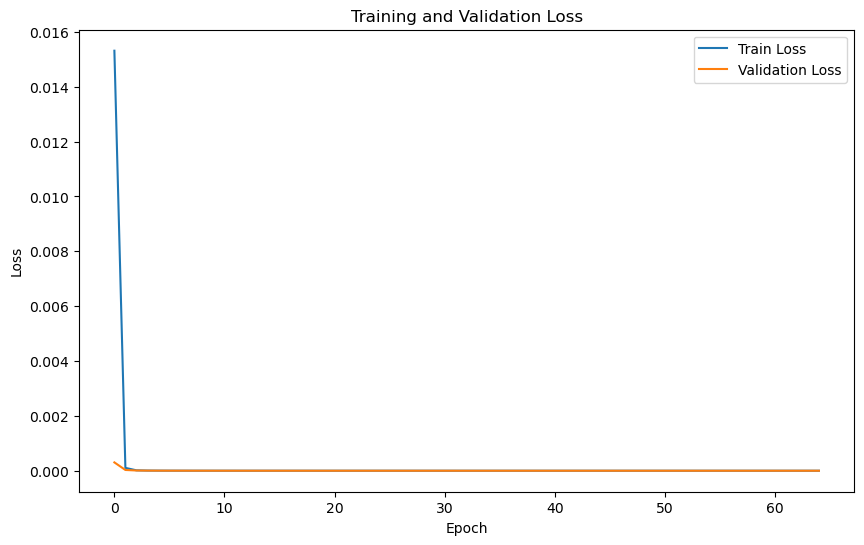

Test RMSE: 0.00018254890164826065
R^2 Score: 0.9999993484791213


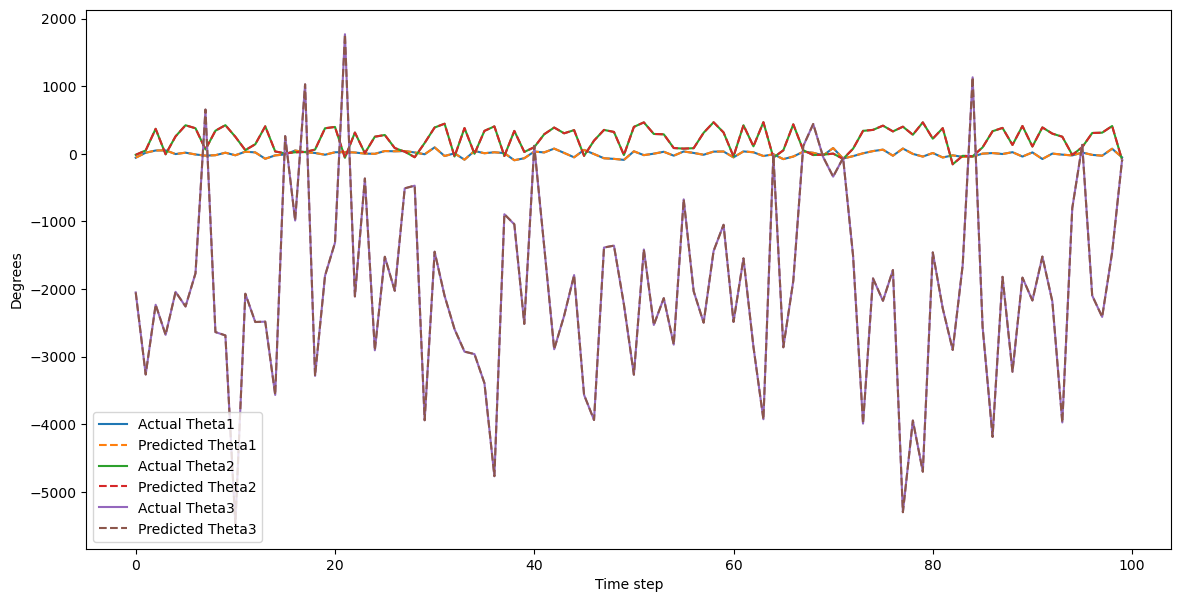

In [15]:
# Create Sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Create Training and Testing Sets
SEQ_LENGTH = 100
X, Y = create_sequences(data, SEQ_LENGTH)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(Y_train, dtype=torch.float32).to(device))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(Y_test, dtype=torch.float32).to(device))

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# Initializing and Defining Vanilla RNN Model
class VanillaRNNModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super(VanillaRNNModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)
    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        last_time_step = rnn_output[:, -1, :]
        y_pred = self.linear(last_time_step)
        return y_pred

input_size = 3
hidden_layer_size = 50
output_size = 3
model = VanillaRNNModel(input_size, hidden_layer_size, output_size).to(device)

# Initializing weights and biases
for name, param in model.named_parameters():
    if 'weight' in name:
        nn.init.xavier_normal_(param)  # Xavier initialization
    elif 'bias' in name:
        nn.init.uniform_(param, -0.1, 0.1)

# Initializing loss and optimizer functions
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
NUM_EPOCHS = 150
PATIENCE = 10

# Training model with loss tracking and early stopping
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, num_epochs, patience):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                y_pred = model(sequences)
                loss = loss_function(y_pred, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping at epoch {epoch+1}')
            break

train_model(model, train_loader, test_loader, NUM_EPOCHS, PATIENCE)

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluating the model
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            y_pred = model(sequences)
            loss = torch.sqrt(loss_function(y_pred, targets))
            test_loss += loss.item()
            # Append predictions and targets without reshaping
            all_predictions.append(y_pred.detach().cpu().numpy())
            all_targets.append(targets.detach().cpu().numpy())
    avg_test_loss = test_loss / len(test_loader)
    # Concatenate along the batch dimension (axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    # Reshape to match for r2_score: (num_samples, num_outputs)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    print(f'Test RMSE: {rmse}')
    r2 = r2_score(all_targets, all_predictions)
    print(f'R^2 Score: {r2}')

evaluate_model(model, test_loader)

# Predict and plot results
model.eval()
with torch.no_grad():
    for sequences, targets in test_loader:
        y_pred = model(sequences)
        break

y_pred_np = y_pred.cpu().numpy()
targets_np = targets.cpu().numpy()

y_pred_original = scaler.inverse_transform(y_pred_np)
targets_original = scaler.inverse_transform(targets_np)

time_steps_to_plot = min(100, len(targets_original))

plt.figure(figsize=(14, 7))
plt.plot(targets_original[:time_steps_to_plot, 0], label='Actual Theta1')
plt.plot(y_pred_original[:time_steps_to_plot, 0], label='Predicted Theta1', linestyle='dashed')
plt.plot(targets_original[:time_steps_to_plot, 1], label='Actual Theta2')
plt.plot(y_pred_original[:time_steps_to_plot, 1], label='Predicted Theta2', linestyle='dashed')
plt.plot(targets_original[:time_steps_to_plot, 2], label='Actual Theta3')
plt.plot(y_pred_original[:time_steps_to_plot, 2], label='Predicted Theta3', linestyle='dashed')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()